In [2]:
import os
import sys
import numpy as np

import matplotlib.pyplot         as plt
import mlem.mlem_reconstruct     as mr
import antea.image.fom_functions as fomf

#sys.stdout = open(os.devnull, "w") ## Prevents from printing

### Configurations to compare: (case of jitter)

#### C: all_events (TOF=119ps), photo_range1mm (TOF=85ps), photo_range3mm (TOF=85ps)
#### RUST: photo_range1mm (TOF=85ps), photo_range3mm (TOF=85ps)

In [3]:
def image_filename_c(path, alg, conf, tof, nc):
    return f'{path}/{alg}_images/{conf}/im_th0.25_TOF{tof}ps_{conf}_jitter_{nc}coinc_iter'

def image_filename_rust(path, alg, conf, tof):
    x, y, z  = (60, 60, 60)
    return f'{path}/{alg}_images/{conf}/reco/{x}_{y}_{z}_reco_{conf}_tof_{tof}_'#{it:02}.raw'

def read_images(path, alg, conf, tof, nc, n_iter, save_every):
    rec = mr.MLEMReconstructor(libpath=path_to_mlem)
    if alg == 'c':
        rec.prefix = image_filename_c(path, alg, conf, tof, nc)
    else:
        rec.prefix = image_filename_rust(path, alg, conf, tof)
    return np.array([rec.read_image(i) for i in range(0, n_iter, save_every)])

path_to_mlem = '/Users/carmenromoluque/tofpet3d/lib/libmlem.so'
im_path      = '/Users/carmenromoluque/nexus_petit_analysis/full-body-phantom-paper/images_reco/jitter/'
#kinds  = (('c',    'all_events',     119, 213650120),
kinds  = (('c',    'photo_range1mm',  85,  20490935),
          ('c',    'photo_range3mm',  85,  36520750), 
          ('rust', 'photo_range1mm',  85,  20490935),
          ('rust', 'photo_range3mm',  85,  36520750))

tot_it     = 30
save_every = 2

from collections import namedtuple

kind_tof   = namedtuple('kind', 'alg conf tof')
the_images = {kind_tof(alg=alg, conf=conf, tof=tof): read_images(im_path, alg, conf, tof, nc, tot_it, save_every) 
              for alg, conf, tof, nc in kinds}

In [4]:
the_images;

In [5]:
def imshow_slice_integrated_along_z(ax, alg, conf, tof, it, z_slice):
    if it < 1:
        it = 1
    image_slice = the_images[kind_tof(alg=alg, conf=conf, tof=tof)][int(it/save_every-1),:,:,z_slice]
    im_integrated_along_z = np.sum(image_slice, axis=2).transpose()
    fig0 = ax.imshow(im_integrated_along_z, origin='lower')
    title = f'{alg}, {conf}'
    ax.set_title(title, fontsize=17)
    ax.set_xlabel('X (mm)', fontsize=13)
    ax.set_ylabel('Y (mm)', fontsize=13)
    #fig.colorbar(fig0, ax=ax, label='Events')

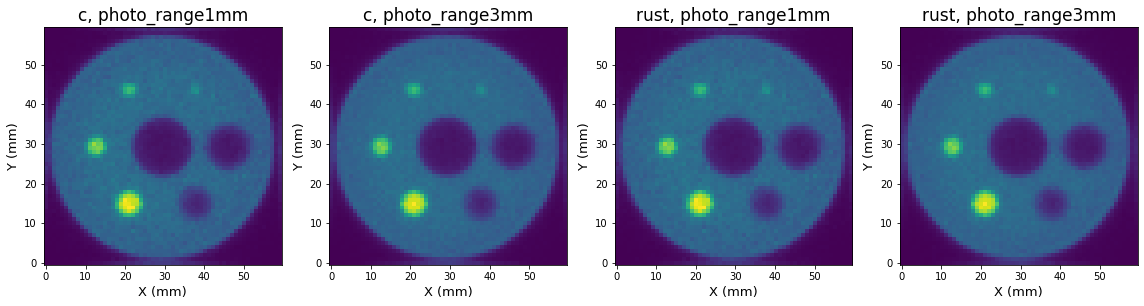

In [6]:
it       = 16
z_slice  = slice(25,35)
fig, axs = plt.subplots(1,4, figsize=(16, 6))
for ax, (alg, conf, tof, _) in zip(axs.flatten(), kinds):
    imshow_slice_integrated_along_z(ax, alg, conf, tof, it, z_slice)
    plt.tight_layout()
plt.show()

In [7]:
sig_intensity  =  4
bckg_intensity =  1
radial_pos     = 50.
bckg_radius    =  4.
phi0           = np.pi/6
phi_step       = np.pi/3
n_phi          = 6

hot_radii   = [4., 6.5, 8.5, 11.]
cold_radii  = [14., 18.5]
all_radii   = hot_radii + cold_radii

hot_angles  = [np.pi/3, 2*np.pi/3, 3*np.pi/3, 4*np.pi/3]
cold_angles = [5*np.pi/3, 6*np.pi/3]

x_size = y_size = z_size = 180
x_bins = y_bins = z_bins =  60

radii  = hot_radii  + cold_radii
angles = hot_angles + cold_angles

In [8]:
num_hot     = 4
num_cold    = 2
num_spheres = num_hot + num_cold

sph_kind_tof = namedtuple('sph_kind_tof', 'sph, alg conf tof')
snr_err      = namedtuple('snr_err'     , 'snrs, errs')

def get_snrs(images, kind_tof, n_sph):
    calculate_snrs_and_errs = lambda images: fomf.snr3d(images, radii[n_sph], radial_pos, angles[n_sph], 
                                                        bckg_radius, phi0, phi_step, n_phi, 
                                                        x_size, y_size, z_size,
                                                        x_bins, y_bins, z_bins)
    all_images = tuple(map(calculate_snrs_and_errs, images[kind_tof]))
    snrs = [r[0] for r in all_images]
    errs = [e[1] for e in all_images]
    print(kind_tof, n_sph)
    return snr_err(snrs=snrs, errs=errs)

snrs = {sph_kind_tof(sph=n_sph, alg=alg, conf=conf, tof=tof) :
        get_snrs(the_images, kind_tof(alg=alg, conf=conf, tof=tof), n_sph)
        for alg, conf, tof, _ in kinds
        for n_sph in range(num_spheres)}

In [9]:
from typing import Sequence
from typing import Dict

def plot_snr_sphs(snrs:    Dict[sph_kind_tof, snr_err], 
                  spheres: Sequence[int], 
                  alg:     str,
                  conf:    str,
                  tof:     int,
                  num_it:  int):
    images_wanted = int(num_it/save_every)
    for n_sphere in spheres:
        sphere = snrs  [sph_kind_tof(sph=n_sphere, alg=alg, conf=conf, tof=tof)]
        plt.errorbar(x = list(range(0, num_it, save_every)),
                     y =    sphere.snrs[:images_wanted], 
                     yerr = sphere.errs[:images_wanted], 
                     xerr = None,
                     #color = color, 
                     marker = 's', 
                     capsize = 3,
                     label =f'sph{n_sphere}, {alg}, pr{conf[-3:]}, TOF={tof}ps')

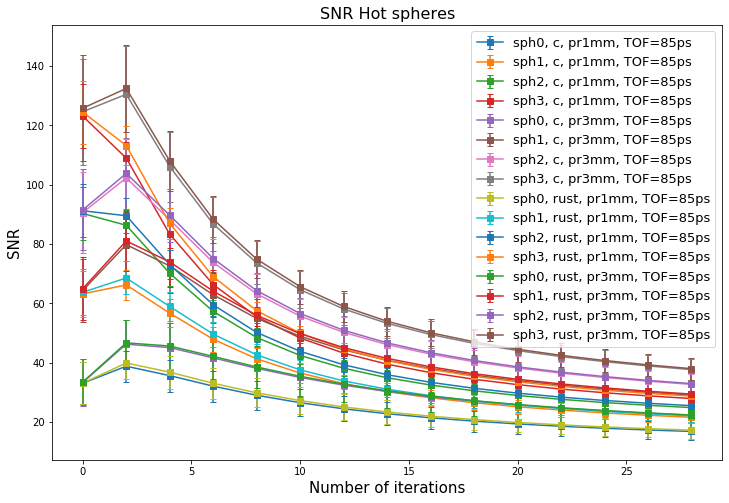

In [10]:
plt.figure(figsize=(12,8))
for alg, conf, tof, _ in kinds[:]:
    plot_snr_sphs(snrs, range(4), alg, conf, tof=tof, num_it=30)
plt.title(f'SNR Hot spheres', fontsize=16)
plt.xlabel('Number of iterations', fontsize=15)
plt.ylabel('SNR', fontsize=15)
plt.legend(loc=1, fontsize=13, ncol=1);

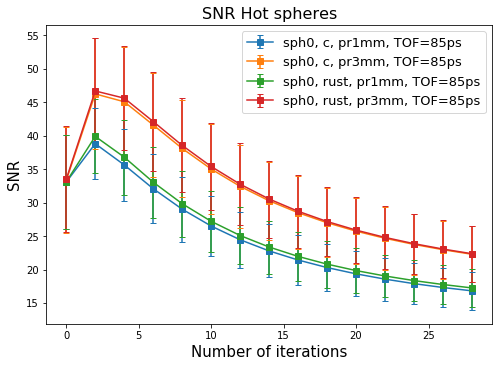

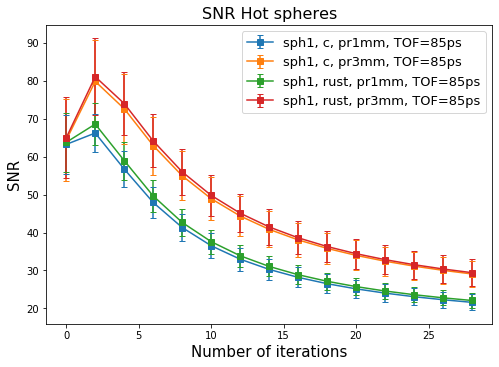

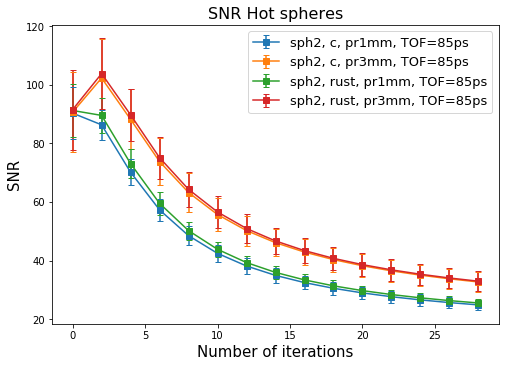

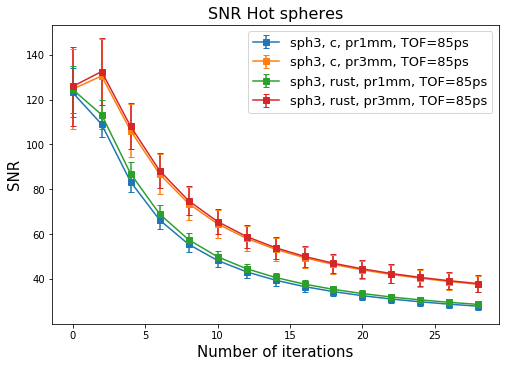

In [11]:
for n_sph in range(4):
    plt.figure(figsize=(8,5.5))
    for alg, conf, tof, _ in kinds[:]:
        plot_snr_sphs(snrs, range(n_sph, n_sph+1), alg, conf, tof=tof, num_it=30)
    plt.title(f'SNR Hot spheres', fontsize=16)
    plt.xlabel('Number of iterations', fontsize=15)
    plt.ylabel('SNR', fontsize=15)
    plt.legend(loc=1, fontsize=13, ncol=1)
    plt.show()

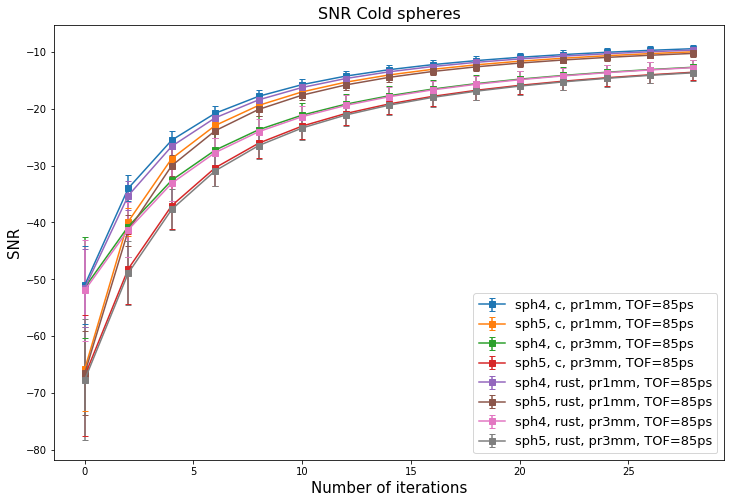

In [12]:
plt.figure(figsize=(12,8))
for alg, conf, tof, _ in kinds[:]:
    plot_snr_sphs(snrs, range(4,6), alg, conf, tof=tof, num_it=30)
plt.title(f'SNR Cold spheres', fontsize=16)
plt.xlabel('Number of iterations', fontsize=15)
plt.ylabel('SNR', fontsize=15)
plt.legend(loc=4, fontsize=13, ncol=1);

## CRC

In [13]:
crc_err = namedtuple('crc_err', 'crcs, errs')
sig_intensity  =  4
bckg_intensity =  1

def get_crcs(images, kind_tof, n_sph):
    calculate_crcs_and_errs = lambda images: fomf.crc_hot3d(images, sig_intensity, bckg_intensity, 
                                                            radii[n_sph], radial_pos, angles[n_sph], 
                                                            bckg_radius, phi0, phi_step, n_phi, 
                                                            x_size, y_size, z_size,
                                                            x_bins, y_bins, z_bins)
    all_images = tuple(map(calculate_crcs_and_errs, images[kind_tof]))
    crcs = [r[0]*100 for r in all_images]
    errs = [e[1]*100 for e in all_images]
    print(kind_tof, n_sph)
    return crc_err(crcs=crcs, errs=errs)

crcs = {sph_kind_tof(sph=n_sph, alg=alg, conf=conf, tof=tof):
        get_crcs(the_images, kind_tof(alg=alg, conf=conf, tof=tof), n_sph)
        for alg, conf, tof, _ in kinds
        for n_sph in range(4)}

In [14]:
def get_crcs_cold(images, kind_tof, n_sph):
    calculate_crcs_and_errs = lambda images: fomf.crc_cold3d(images, radii[n_sph], radial_pos, angles[n_sph], 
                                                             bckg_radius, phi0, phi_step, n_phi, 
                                                             x_size, y_size, z_size,
                                                             x_bins, y_bins, z_bins)
    all_images = tuple(map(calculate_crcs_and_errs, images[kind_tof]))
    crcs = [r[0]*100 for r in all_images]
    errs = [e[1]*100 for e in all_images]
    print(kind_tof, n_sph)
    return crc_err(crcs=crcs, errs=errs)

crcs_cold = {sph_kind_tof(sph=n_sph, alg=alg, conf=conf, tof=tof):
             get_crcs(the_images, kind_tof(alg=alg, conf=conf, tof=tof), n_sph)
             for alg, conf, tof, _ in kinds
             for n_sph in range(4, 6)}

In [25]:
def plot_crc_sphs(crcs:    Dict[sph_kind_tof, crc_err], 
                  spheres: Sequence[int], 
                  alg:     str,
                  conf:    str,
                  tof:     int,
                  num_it:  int):
    images_wanted = int(num_it/save_every)
    for n_sphere in spheres:
        sphere = crcs[sph_kind_tof(sph=n_sphere, alg=alg, conf=conf, tof=tof)]
        plt.errorbar(x = list(range(0, num_it, save_every)),
                     y =    sphere.crcs[:images_wanted], 
                     yerr = sphere.errs[:images_wanted], 
                     xerr = None,
                     marker = 's', 
                     capsize = 3,
                     label =f'sph{n_sphere}, {alg}, pr{conf[-3:]}, TOF={tof}ps')

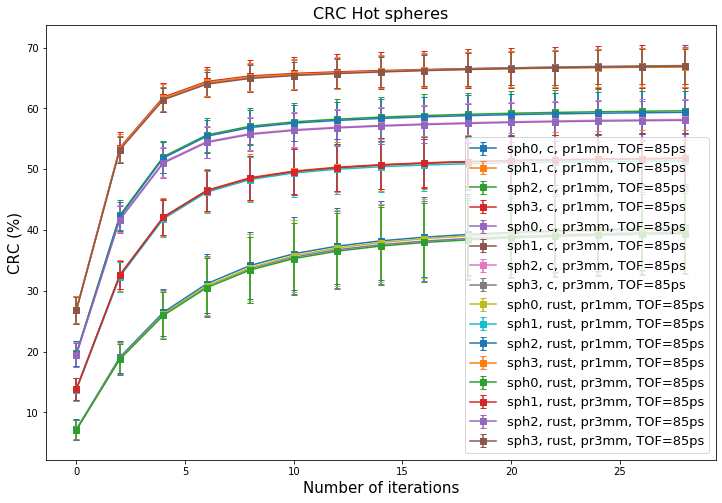

In [29]:
plt.figure(figsize=(12,8))
for alg, conf, tof, _ in kinds[:]:
    plot_crc_sphs(crcs, range(4), alg, conf, tof=tof, num_it=30)
plt.title(f'CRC Hot spheres', fontsize=16)
plt.xlabel('Number of iterations', fontsize=15)
plt.ylabel('CRC (%)', fontsize=15)
plt.legend(loc=4, fontsize=13, ncol=1);

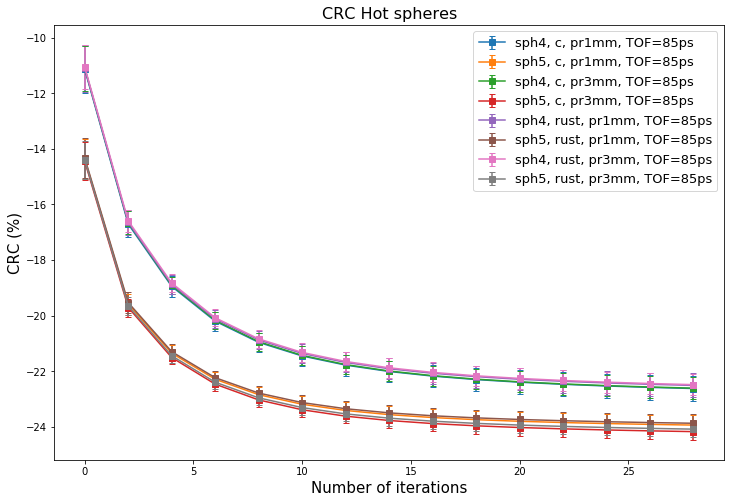

In [32]:
plt.figure(figsize=(12,8))
for alg, conf, tof, _ in kinds[:]:
    print(alg, conf, tof)
    plot_crc_sphs(crcs_cold, range(4,6), alg, conf, tof=tof, num_it=30)
plt.title(f'CRC Hot spheres', fontsize=16)
plt.xlabel('Number of iterations', fontsize=15)
plt.ylabel('CRC (%)', fontsize=15)
plt.legend(loc=1, fontsize=13, ncol=1);